In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("syedhaideralizaidi/bike-sharing-demand-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bike-sharing-demand-dataset


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler


In [4]:
df= pd.read_csv("/kaggle/input/bike-sharing-demand-dataset/Bike sharing.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df.shape

(10886, 12)

In [6]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [7]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#I need to change the datetime column and extract useful information from it

In [9]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df["weekday"] = df["datetime"].dt.weekday

In [10]:
df=df.drop("datetime",axis=1) #dropping it since I no longer need it

In [11]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year,weekday
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1,2011,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,2011,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1,2011,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1,2011,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1,2011,5


In [12]:
corr=df.corr()["count"].sort_values(ascending=False)
corr

count         1.000000
registered    0.970948
casual        0.690414
hour          0.400601
temp          0.394454
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
windspeed     0.101369
day           0.019826
workingday    0.011594
weekday      -0.002283
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64

<Axes: >

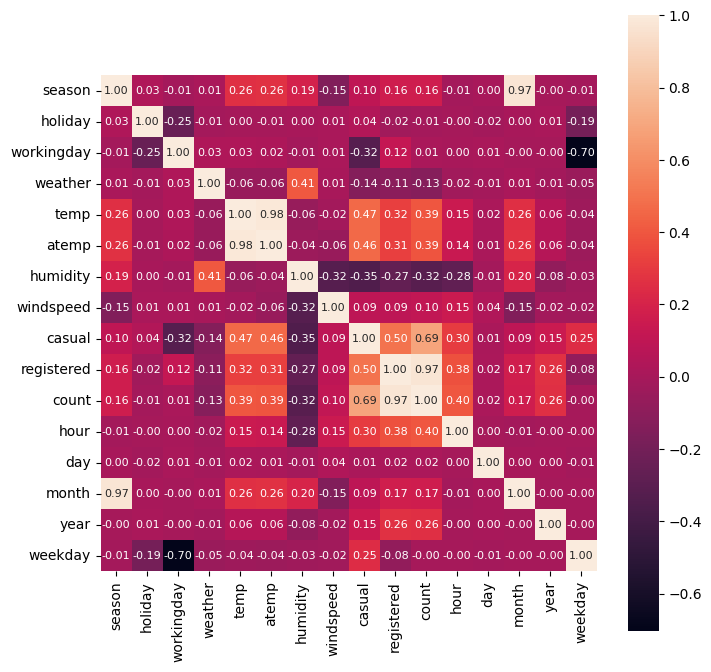

In [13]:
corrlation = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrlation,cbar=True,annot=True,square=True,fmt=".2f",annot_kws={"size":8})

In [14]:
X = df.drop(columns=['count', 'casual', 'registered'])  # count=casual + registered that is why I'm dropping them to avoid data leakage
Y = df['count']
print(X,Y)

       season  holiday  workingday  weather   temp   atemp  humidity  \
0           1        0           0        1   9.84  14.395        81   
1           1        0           0        1   9.02  13.635        80   
2           1        0           0        1   9.02  13.635        80   
3           1        0           0        1   9.84  14.395        75   
4           1        0           0        1   9.84  14.395        75   
...       ...      ...         ...      ...    ...     ...       ...   
10881       4        0           1        1  15.58  19.695        50   
10882       4        0           1        1  14.76  17.425        57   
10883       4        0           1        1  13.94  15.910        61   
10884       4        0           1        1  13.94  17.425        61   
10885       4        0           1        1  13.12  16.665        66   

       windspeed  hour  day  month  year  weekday  
0         0.0000     0    1      1  2011        5  
1         0.0000     1    1    

In [15]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=1)
print(X_train.shape,X_test.shape)

(8708, 13) (2178, 13)


RandomForestRegressor


R2 is  0.9525842856312876
RMSE is  40.21047377422756
MAE is  24.56904958677686




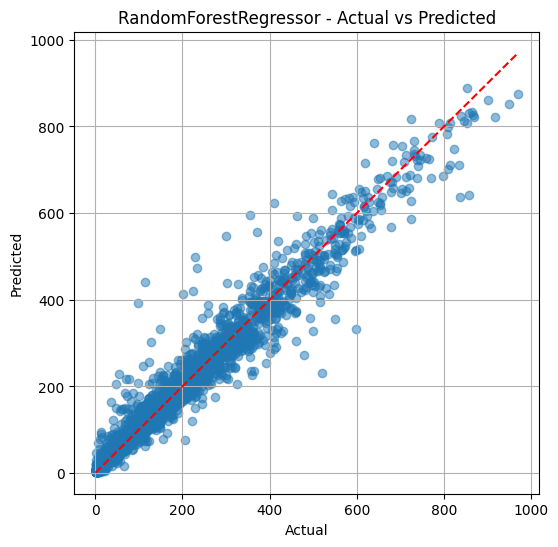

XGBRegressor


R2 is  0.9562719243371571
RMSE is  38.61519426480551
MAE is  24.694968173727634




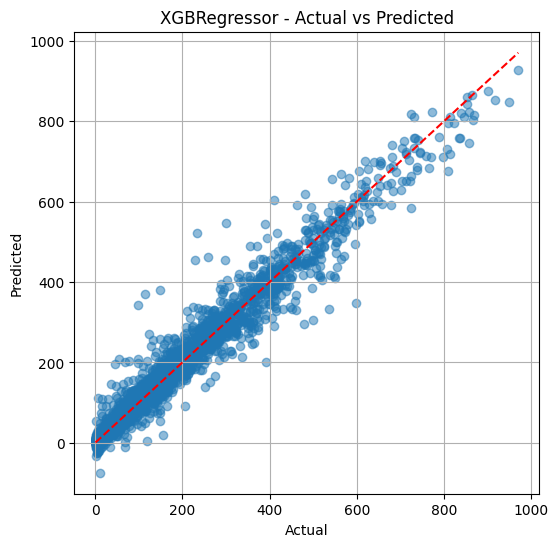

In [16]:
models = [
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBRegressor", XGBRegressor()),
]
# storing the models in list of tuples just for easier code
for name, model in models:
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    # R2
    r2 = r2_score(Y_test,Y_pred)
    # RMSE
    RMSE = np.sqrt(mean_squared_error(Y_test,Y_pred))
    #MAE
    MAE = mean_absolute_error(Y_test,Y_pred)


    print(name)
    print("\n")
    print("R2 is ", r2)
    print("RMSE is ",RMSE)
    print("MAE is ",MAE)
    print("\n")

    # Plot
    plt.figure(figsize=(6,6))
    plt.scatter(Y_test, Y_pred, alpha=0.5)
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} - Actual vs Predicted")
    plt.grid()
    plt.show()

